In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt

import numpy as np
import scipy.optimize
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Studying information geometric applications for exponential families
https://arxiv.org/pdf/0709.2196.pdf

We first go with the exponential family of gaussians, i.e. $t(x) = [x, x^2]^T$.

It then holds:
$$F(\theta) = \log\int_{-\infty}^{\infty} \exp(\theta_1x + \theta_2x^2)\text{d}x = - \frac{\theta_1^2}{4\theta_2} + \frac{1}{2} \log \frac{\pi}{-\theta_2}$$

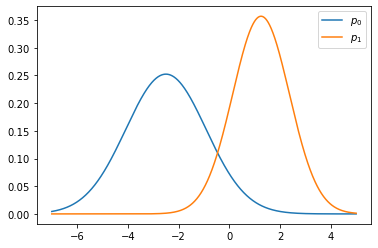

In [2]:
X = np.linspace(-7, 5, 1000)

# gaussian statistics vector
def t_gaussian(X):
    return [X, X**2]


def exp(X, theta, t):
    t_val = t(X)
    theta_val = np.tile(theta, (len(X), 1)).transpose()
    if len(theta) == 2: #gaussian
        eF = F_gaussian(theta)
    else:
        eF = F(X, theta, t) # try to estimate F
    
    return np.exp(np.sum(t_val*theta_val, axis=0)-eF)

def F_gaussian(theta):
    return -theta[0]**2/(4*theta[1]) + 1/2 * np.log(np.pi/-theta[1])

def F(X, theta, t):
    t_val = t(X)
    if len(t_val) != len(theta):
        raise ValueError("t_val and theta must have the same length")

    theta_val = np.tile(theta, (len(X), 1)).transpose()
    return np.sum(np.exp(np.sum(t_val*theta_val, axis=0)))

theta0 = np.array([-1, -0.2])
theta1 = np.array([1,  -0.4])
plt.plot(X, exp(X, theta0, t_gaussian), label="$p_0$")
plt.plot(X, exp(X, theta1, t_gaussian), label="$p_1$")
plt.legend()
plt.show();


We can then obtian the dual coordinates
$$\eta_1 = \partial_1 F(\theta) = -\frac{\theta_1}{2 \theta_2} $$
$$\eta_2 = \partial_2 F(\theta) = \frac{\theta_1^2 - 2 \theta_2}{4 \theta_2^2}$$

And this way, the Bregmann divergence and Bregmann bisector of both types.

We also can compute the legendre transform, done here using Mathematica(see attached notebook)
$$F^*(\eta) = - \frac{1}{2}\left(1 + \log(-2 \pi (\eta_1^2 -\eta_2) \right)$$


In [3]:
plt.rcParams["figure.figsize"] = (15,15)
def dF_gaussian(theta):
    return np.array([-theta[0]/(2*theta[1]), (theta[0]**2 - 2 * theta[1])/(4*theta[1]**2)])

def eta(theta):
    return dF_gaussian(theta)

def F(theta):
    return F_gaussian(theta)

def Fs(eta):
    return -1/2*(1+ np.log(-2* np.pi*(eta[0]**2 -eta[1])))

def B_F_gaussian(theta, theta_hat):
    return F_gaussian(theta) - F_gaussian(theta_hat) - np.tensordot(dF_gaussian(theta_hat),theta - theta_hat[:,None,None], axes=(0,0))


def middle_distance_first(theta, theta1, theta2):
    return np.tensordot(theta, eta(theta1) - eta(theta2), axes=(0,0)) + \
        F(theta1) - np.inner(theta1,eta(theta1)) - F(theta2) + np.inner(theta2, eta(theta2))

def middle_distance_second(theta, theta1, theta2):
    return np.tensordot(eta(theta), theta2-theta1, axes=(0,0)) + F(theta1) - F(theta2)

def middle_distance_third(theta, theta1, theta2):
    return np.tensordot(theta, eta(theta1) - eta(theta2), axes=(0,0)) + \
        np.tensordot(eta(theta), theta1-theta2, axes=(0,0)) + \
        - np.inner(theta1,eta(theta1)) + np.inner(theta2, eta(theta2))

X = np.linspace(-1.2,1.5, 100)
Y = np.linspace(-2, 0, 100)

xx,yy = np.meshgrid(X,Y)

def f(theta01, theta02, theta11, theta12 ):
    theta0 = np.array([theta01, theta02])
    theta1 = np.array([theta11, theta12])
    
    ax = plt.subplot(111)
    # set aspect ratio to 1 to make the plot square
    plt.gca().set_aspect('equal', adjustable='box')

    plt.plot(theta0[0], theta0[1], "o", label="$p_0$")
    plt.plot(theta1[0], theta1[1], "o", label="$p_1$")
    plt.legend()
    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$\theta_2$")


    B_F0 = B_F_gaussian(np.array([xx,yy]),theta0)
    B_F1 = B_F_gaussian(np.array([xx,yy]),theta1)
    ax.contour(xx,yy,B_F0,levels=[ 1e-2, 1e-1,1], colors="black", linestyles="dashed", )
    ax.contour(xx,yy,B_F1,levels=[ 1e-2, 1e-1,1], colors="black", linestyles="dashed")

    mids1 = middle_distance_first(np.array([xx,yy]), theta0, theta1)
    ax.contour(xx,yy,mids1,levels=[ 0], colors="blue")


    mids2 = middle_distance_second(np.array([xx,yy]), theta0, theta1)
    ax.contour(xx,yy,mids2,levels=[ 0], colors="purple")

    mids3 = middle_distance_third(np.array([xx,yy]), theta0, theta1)
    ax.contour(xx,yy,mids3,levels=[ 0], colors="green")

    
    plt.plot([theta0[0],theta1[0]], [theta0[1], theta1[1]], color="gray", alpha=0.2)
    plt.legend()
    plt.show();
    
    
# interact with sliders
interact(f, 
         theta01=widgets.FloatSlider(min=X[0], max=X[-1], step=0.01, value=0.33),
         theta02=widgets.FloatSlider(min=Y[0], max=Y[-1], step=0.01, value=-0.33),
         theta11=widgets.FloatSlider(min=X[0], max=X[-1], step=0.01, value=0.33),
         theta12=widgets.FloatSlider(min=Y[0], max=Y[-1], step=0.01, value=-0.5),);

interactive(children=(FloatSlider(value=0.33, description='theta01', max=1.5, min=-1.2, step=0.01), FloatSlide…